# llc4320 drifters spectra

Computes periodograms over rolling windows

In [1]:
import os
#from glob import glob

import numpy as np
import pandas as pd
import xarray as xr

import dask.dataframe as dd

%matplotlib inline
from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
import mitequinox.parcels as pa
import mitequinox.drifters as dr

In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster()
    cluster = PBSCluster(cores=28, processes=14)
    w = cluster.scale(jobs=4)
    #
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

In [10]:
client

Client Scheduler: tcp://10.148.0.253:55275 Dashboard: http://10.148.0.253:8787/status,Cluster Workers: 56 Cores: 112 Memory: 479.92 GB


---
## load data

In [11]:
root_dir = '/home1/datawork/aponte/parcels/'
run_name = 'global_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['trajectory'])
df = p.df['trajectory']

In [12]:
# add time in seconds
df = df.rename(columns={'time': 'date'})
t_start = df.date.min().compute()
df['time'] = (df['date'] - t_start)/pd.Timedelta('1D')

# Should check time sampling

df = df.persist()
# 5GB on disk, 25GB in memory

df.head()

,date,lat,lon,z,time
trajectory,,,,,
4000000.0,2011-11-15,41.797028,-34.864582,0.0,0.0
4000001.0,2011-11-15,42.514122,-34.864582,0.0,0.0
4000002.0,2011-11-15,43.223770,-34.864582,0.0,0.0
4000003.0,2011-11-15,43.925968,-34.864582,0.0,0.0
4000004.0,2011-11-15,44.620720,-34.864582,0.0,0.0


---

## start processing

In [13]:
def process_window(lon, lat, N, dt, **kwargs):
    ''' Wraps spectral calculation: add complex velocity
    Assumes the time series is regularly sampled
    
    Parameters:
    -----------
        lon,lat: pd.Series
            Longitude index by time (in days)
        N: int,
            length of the spectrum
        dt: float
            Time sampling in days
        **kwargs:
            passed to mit_equinox.drifters.get_spectrum
    '''
    if lon is None:
        uv = None
    else:
        # compute displacements
        lon1, lat1 = lon.shift(periods=-1), lat.shift(periods=-1)
        u = dr.haversine(lon, lat, lon1, lat)*1e3 *np.sign(lon1-lon) /dt/86400
        v = dr.haversine(lon, lat, lon, lat1)*1e3 *np.sign(lat1-lat) /dt/86400
        u = pd.Series(u, index=lon.index).fillna(method='ffill')
        v = pd.Series(v, index=lon.index).fillna(method='ffill')
        uv = (u + 1j*v)
    return dr.get_spectrum(uv, N, dt=dt, **kwargs)

**Cell below is the computationnally intensive part**

Peaks at 220GB of RAM

In [14]:
T = 60 # days
dt = 1/24 # sampling
N = int(T/dt) # output size

df_chunked = (df.reset_index() # don't understand why reset_index is required here
              .groupby('trajectory')
              .apply(dr.time_window_processing,
                     process_window,
                     ['lon', 'lat'],
                     T, 
                     N,
                     id_label='trajectory',
                     dt=1/24.,
                    )
              .persist()
             )

<ipython-input-14-3746fd5f957c>:5: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_chunked = (df.reset_index() # don't understand why reset_index is required here


In [15]:
# the dataframe partitions has a multi-index: id and window central time (unknow name for now)
# we first transform the index corresponding to time into a regular column.
df_chunked = (
              df_chunked.map_partitions(
                  lambda df: df.reset_index(level=[1]).rename(columns={'level_1': 'time'})
                                       )
              )
df_chunked = df_chunked.drop(columns='id')
df_chunked.head()

,time,lon,lat,0.0,0.016666666666666666,0.03333333333333333,0.05,0.06666666666666667,0.08333333333333333,0.1,...,-0.16666666666666666,-0.15,-0.13333333333333333,-0.11666666666666667,-0.1,-0.08333333333333333,-0.06666666666666667,-0.05,-0.03333333333333333,-0.016666666666666666
trajectory,,,,,,,,,,,,,,,,,,,,,
1000038.0,30.0,-33.678881,-52.595288,0.523641,0.133140,0.111806,0.146029,0.011571,0.165782,0.058233,...,0.018080,0.030102,0.025955,0.083733,0.041961,0.091455,0.063057,0.045595,0.088134,0.338575
1000038.0,60.0,-29.241215,-50.968007,1.198616,0.324144,0.253692,0.289772,0.034247,0.066533,0.171081,...,0.051082,0.030627,0.003433,0.124832,0.255855,0.046321,0.063949,0.071451,0.159166,0.631016
1000038.0,90.0,-24.904095,-49.557740,0.364320,0.615903,0.426502,0.080770,0.001694,0.041981,0.066821,...,0.002437,0.019262,0.094436,0.004444,0.225537,0.198654,0.091767,0.035636,0.247881,0.036401
1000038.0,120.0,-22.196490,-49.063968,0.189821,0.383676,0.272813,0.101550,0.110597,0.041528,0.031561,...,0.011883,0.041587,0.119102,0.080767,0.019082,0.008024,0.042308,0.020339,0.171859,0.035318
1000038.0,150.0,-17.624424,-49.277892,1.581497,0.533929,0.485459,0.657920,0.155169,0.017655,0.014590,...,0.041501,0.079666,0.102995,0.060941,0.041437,0.337928,0.935686,0.513415,0.009146,0.913456


In [16]:
# store to parquet
df_chunked.columns = df_chunked.columns.astype(str) # fastparquet does not allow float column names
p.store_diagnostic('spectra_raw', df_chunked, overwrite=True)

No reindexing
deleting existing archive: /home1/datawork/aponte/parcels/global_T365j_dt1j_dij50/diagnostics/spectra_raw
create new archive: /home1/datawork/aponte/parcels/global_T365j_dt1j_dij50/diagnostics/spectra_raw


**Could move to another notebook from here**

In [5]:
# read parquet file
df_chunked = p.load_diagnostic('spectra_raw')

In [17]:
df_chunked = df_chunked.persist()
df_chunked.head()

,time,lon,lat,0.0,0.016666666666666666,0.03333333333333333,0.05,0.06666666666666667,0.08333333333333333,0.1,...,-0.16666666666666666,-0.15,-0.13333333333333333,-0.11666666666666667,-0.1,-0.08333333333333333,-0.06666666666666667,-0.05,-0.03333333333333333,-0.016666666666666666
trajectory,,,,,,,,,,,,,,,,,,,,,
1000038.0,30.0,-33.678881,-52.595288,0.523641,0.133140,0.111806,0.146029,0.011571,0.165782,0.058233,...,0.018080,0.030102,0.025955,0.083733,0.041961,0.091455,0.063057,0.045595,0.088134,0.338575
1000038.0,60.0,-29.241215,-50.968007,1.198616,0.324144,0.253692,0.289772,0.034247,0.066533,0.171081,...,0.051082,0.030627,0.003433,0.124832,0.255855,0.046321,0.063949,0.071451,0.159166,0.631016
1000038.0,90.0,-24.904095,-49.557740,0.364320,0.615903,0.426502,0.080770,0.001694,0.041981,0.066821,...,0.002437,0.019262,0.094436,0.004444,0.225537,0.198654,0.091767,0.035636,0.247881,0.036401
1000038.0,120.0,-22.196490,-49.063968,0.189821,0.383676,0.272813,0.101550,0.110597,0.041528,0.031561,...,0.011883,0.041587,0.119102,0.080767,0.019082,0.008024,0.042308,0.020339,0.171859,0.035318
1000038.0,150.0,-17.624424,-49.277892,1.581497,0.533929,0.485459,0.657920,0.155169,0.017655,0.014590,...,0.041501,0.079666,0.102995,0.060941,0.041437,0.337928,0.935686,0.513415,0.009146,0.913456


In [18]:
# bin geographically
lat_bins = np.arange(-60, 60, 1.)
lat_idx = pd.IntervalIndex.from_breaks(lat_bins)
df_chunked['lat_cut'] = df_chunked['lat'].map_partitions(pd.cut, bins=lat_bins)

E = df_chunked.groupby(['lat_cut']).mean().compute()

#Converting pandas dataframe in xarray dataset:
ds = (pd.melt(E.set_index(E.index.map(lambda v: v.mid))
              .drop(columns=['time','lon','lat'])
              .reset_index(), id_vars=['lat_cut',], var_name='frequency')
              .rename(columns={'lat_cut': 'lat_bins', 'value': 'E'})
     ).to_xarray().set_index(index=['lat_bins','frequency']).unstack()
ds['frequency'] = ds['frequency'].astype(float)
ds = ds.sortby('frequency')

# store diagnostic (not done here)
#p.store_diagnostic('spectra_lat', ds, overwrite=True)

# may be loaded with 
#ds = p.load_diagnostic('spectra_lat.zarr')

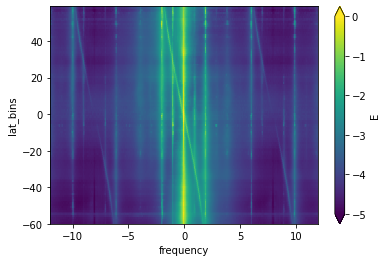

In [19]:
np.log10(ds.E).plot(vmin=-5., vmax=0.)

## Close cluster

In [ ]:
cluster.close()